In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
# Load Fashion MNIST
(X, y), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [33]:
# Normalize and reshape
X = X.astype('float32') / 255.0
X = np.expand_dims(X, -1)  # Add channel dimension

In [34]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# One-hot encode
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_val_cat = tf.keras.utils.to_categorical(y_val, 10)

In [36]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [37]:
# Build CNN Model with Residual + Attention
def build_model():
    inputs = layers.Input(shape=(28, 28, 1))

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Residual block
    residual = layers.Conv2D(32, (3, 3), padding='same')(x)
    residual = layers.BatchNormalization()(residual)
    residual = layers.ReLU()(residual)

    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, residual])
    x = layers.MaxPooling2D((2, 2))(x)

    # Attention block
    attention = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.Add()([x, attention])

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [38]:
# Compile model
model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 14, 14,    │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 14, 14,    │      9,248 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 32)  │          0 │ add_2[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 7, 7, 32)  │      8,416 │ max_pooling2d_3[… │
│ (MultiHeadAttentio… │                   │            │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 7, 7, 32)  │          0 │ max_pooling2d_3[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1568)      │          0 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    200,832 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │      1,290 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,738 (897.41 KB)

 Trainable params: 229,546 (896.66 KB)

 Non-trainable params: 192 (768.00 B)

In [39]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)

In [40]:
# Training
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    epochs=30,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 120s 77ms/step - accuracy: 0.6274 - loss: 1.0649 - val_accuracy: 0.8317 - val_loss: 0.4683 - learning_rate: 0.0010
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 119s 80ms/step - accuracy: 0.7674 - loss: 0.6201 - val_accuracy: 0.8420 - val_loss: 0.4553 - learning_rate: 0.0010
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 121s 80ms/step - accuracy: 0.7963 - loss: 0.5504 - val_accuracy: 0.8053 - val_loss: 0.5917 - learning_rate: 0.0010
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 117s 78ms/step - accuracy: 0.8073 - loss: 0.5169 - val_accuracy: 0.8558 - val_loss: 0.3950 - learning_rate: 0.0010
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 116s 77ms/step - accuracy: 0.8172 - loss: 0.4962 - val_accuracy: 0.8455 - val_loss: 0.4054 - learning_rate: 0.0010
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 119s 79ms/step - accuracy: 0.8275 - loss: 0.4697 - val_accuracy: 0.8667 - val_loss: 0.3554 - learning_rate: 0.0010
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 116s 77ms/step - accuracy: 

In [41]:
# Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Loss: 0.2492
Validation Accuracy: 0.9083


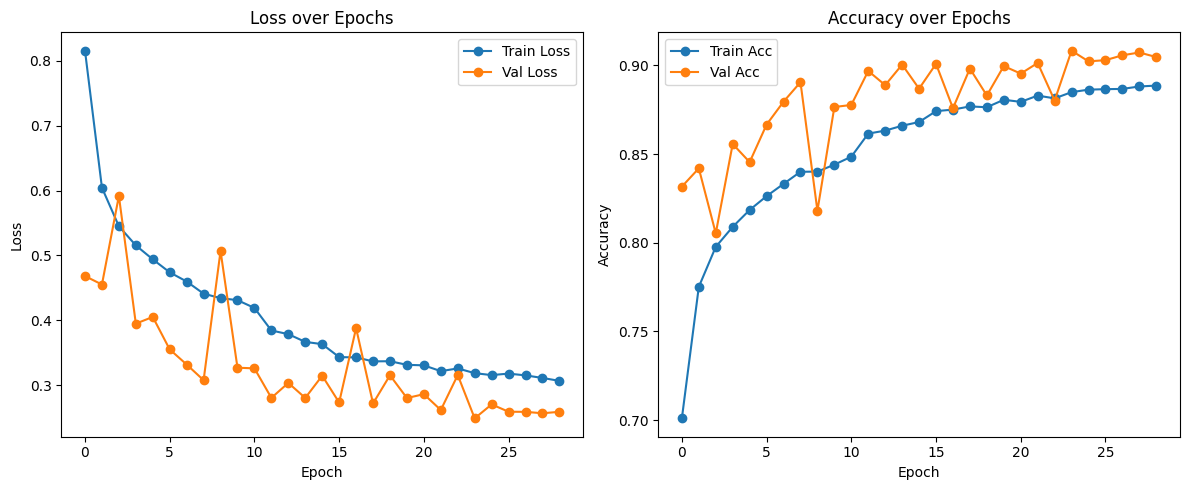

In [42]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
# Predict class indices
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step


In [44]:
# Classification report
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1202
           1       0.99      0.98      0.99      1219
           2       0.88      0.89      0.88      1205
           3       0.92      0.88      0.90      1184
           4       0.86      0.83      0.84      1202
           5       0.97      0.99      0.98      1211
           6       0.72      0.74      0.73      1218
           7       0.95      0.97      0.96      1159
           8       0.98      0.99      0.98      1197
           9       0.98      0.96      0.97      1203

    accuracy                           0.91     12000
   macro avg       0.91      0.91      0.91     12000
weighted avg       0.91      0.91      0.91     12000



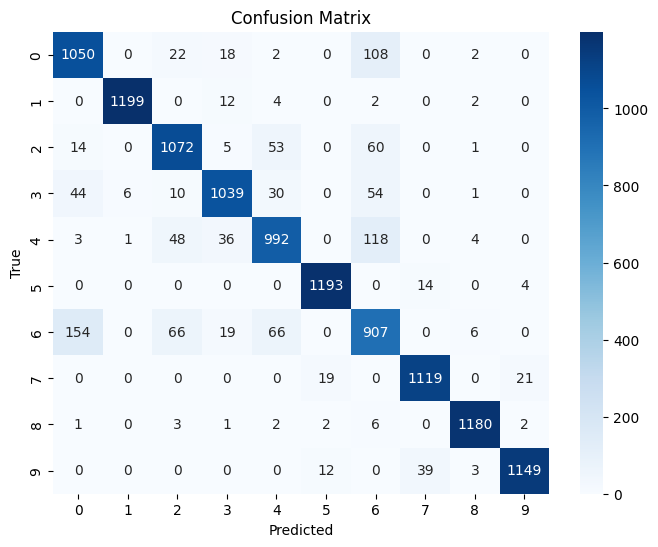

In [45]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

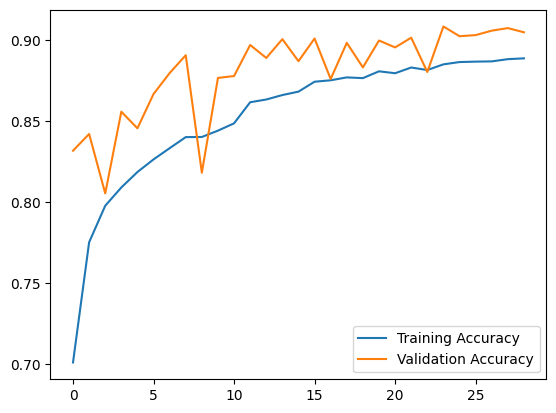

In [47]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [63]:
feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer(index=-3).output)
features = feature_extractor.predict(X_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step


In [71]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=6, metric='cosine')  # 1 original + 5 recs
knn.fit(features)
distances, indices = knn.kneighbors(features[image_index].reshape(1, -1))

In [73]:
# Recommendation function
def recommend_fashion_item(image_index, num_recommendations=5):
    # Use X_val instead of X_test
    features = extract_features(X_val)
    similarities = calculate_similarity(features[image_index].reshape(1, -1), features)
    top_indices = np.argsort(-similarities[0])[:num_recommendations]
    return top_indices

In [74]:
# Test recommendation function
image_index = 10
recommended_indices = recommend_fashion_item(image_index)
print("Recommended fashion items:", recommended_indices)

375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
Recommended fashion items: [ 3425 10851    10  8770  8350]


In [75]:
import matplotlib.pyplot as plt

def plot_recommendations(image_index, recommended_indices):
    # Display the original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, len(recommended_indices) + 1, 1)
    plt.imshow(X_val[image_index].reshape(28, 28), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Display the recommended images
    for i, index in enumerate(recommended_indices):
        plt.subplot(1, len(recommended_indices) + 1, i + 2)
        plt.imshow(X_val[index].reshape(28, 28), cmap='gray')
        plt.title(f"Recommendation {i + 1}")
        plt.axis('off')

    plt.show()

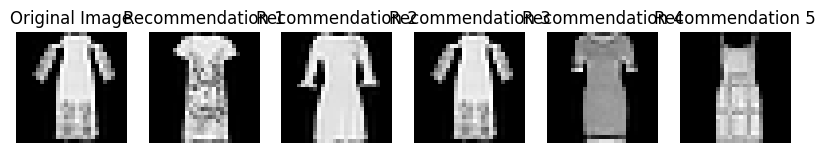

In [76]:
# Show Results
plot_recommendations(image_index, recommended_indices)

In [78]:
model.save("model.h5")